In [14]:
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D

### Transfer Learning Without Fine Tuning:

In [15]:
def plot_training(history):
    """Ultra simple plot function"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.show()


In [16]:
def train_dataset(config):
  CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
  IMG_CHANNELS = 3

  def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

  def parse_csvline(csv_line):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)
    img = read_and_decode(filename, [128, 128])  # Fixed: pass as list
    label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
    return img, label

  train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE))

  eval_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE)
      )
  base_model=tf.keras.applications.MobileNetV2(
      input_shape=(128,128,3),
      include_top=False, # Remove classification head
      weights="imagenet" # Load weights trained on ImageNet
  )
  base_model.trainable=False # Freeze Base

  model=Sequential([
      base_model,
      GlobalAveragePooling2D(),
      BatchNormalization(),
      Dense(len(CLASS_NAMES),activation="softmax")
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=["accuracy"])

  history = model.fit(
      train_dataset,
      validation_data=eval_dataset,
      epochs=5,
      verbose=1,
      callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

  plot_training(history)
  return history, model




Starting Transfer Learning with MobileNetV2
Configuration:
   model: MobileNetV2
   input_size: 128
   batch_size: 32
   epochs: 5
Epoch 1/5
    104/Unknown 135s 1s/step - accuracy: 0.6096 - loss: 1.0827

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


104/104 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6107 - loss: 1.0796 - val_accuracy: 0.8351 - val_loss: 0.4988
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8623 - loss: 0.4001 - val_accuracy: 0.8486 - val_loss: 0.4200
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9014 - loss: 0.2981 - val_accuracy: 0.8649 - val_loss: 0.3957
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9296 - loss: 0.2347 - val_accuracy: 0.8757 - val_loss: 0.3881
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9523 - loss: 0.1898 - val_accuracy: 0.8730 - val_loss: 0.3873


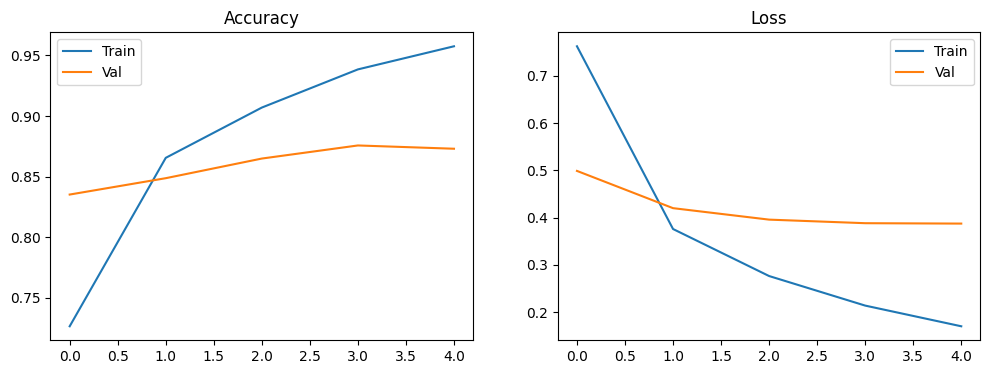


Transfer Learning Completed!
Check the plots above for training performance!


In [17]:
if __name__ == "__main__":
    config = {
        'model': 'MobileNetV2',
        'input_size': 128,
        'batch_size': 32,
        'epochs': 5
    }

    print("Starting Transfer Learning with MobileNetV2")
    print("="*50)
    print("Configuration:")
    for key, value in config.items():
        print(f"   {key}: {value}")
    print("="*50)

    # Run training and get plots
    history, model = train_dataset(config)

    print("\nTransfer Learning Completed!")
    print("Check the plots above for training performance!")

### Transfer Learning With Fine Tuning

In [18]:
def train_dataset(config):
  CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
  IMG_CHANNELS = 3

  def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

  def parse_csvline(csv_line):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)
    img = read_and_decode(filename, [128, 128])  # Fixed: pass as list
    label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
    return img, label

  train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE))

  eval_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE)
      )
  base_model=tf.keras.applications.MobileNetV2(
      input_shape=(128,128,3),
      include_top=False, # Remove classification head
      weights="imagenet" # Load weights trained on ImageNet
  )
  base_model.trainable=True # Unfreeze Base

  model=Sequential([
      base_model,
      GlobalAveragePooling2D(),
      BatchNormalization(),
      Dense(len(CLASS_NAMES),activation="softmax")
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=["accuracy"])

  history = model.fit(
      train_dataset,
      validation_data=eval_dataset,
      epochs=5,
      verbose=1,
      callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

  plot_training(history)
  return history, model




Starting Transfer Learning with MobileNetV2
Configuration:
   model: MobileNetV2
   input_size: 128
   batch_size: 32
   epochs: 5
Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.7161 - loss: 1.0224 - val_accuracy: 0.2838 - val_loss: 14.3743
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.8339 - loss: 0.5084 - val_accuracy: 0.4784 - val_loss: 8.9536
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8849 - loss: 0.3648 - val_accuracy: 0.4595 - val_loss: 10.1605
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9443 - loss: 0.1934 - val_accuracy: 0.2486 - val_loss: 16.4295
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.9535 - loss: 0.1351 - val_accuracy: 0.3703 - val_loss: 10.1072


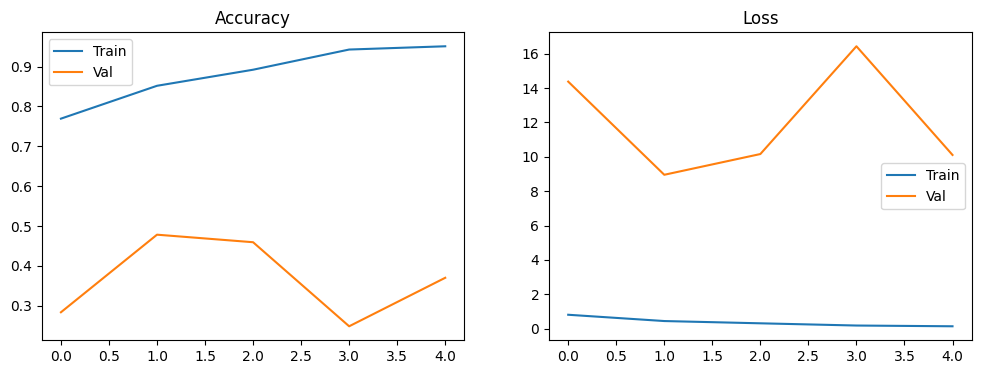


Transfer Learning Completed!
Check the plots above for training performance!


In [19]:
if __name__ == "__main__":
    config = {
        'model': 'MobileNetV2',
        'input_size': 128,
        'batch_size': 32,
        'epochs': 5
    }

    print("Starting Transfer Learning with MobileNetV2")
    print("="*50)
    print("Configuration:")
    for key, value in config.items():
        print(f"   {key}: {value}")
    print("="*50)

    # Run training and get plots
    history, model = train_dataset(config)

    print("\nTransfer Learning Completed!")
    print("Check the plots above for training performance!")